In [391]:
import pandas as pd
import os
from os.path import join
import pylab as plt

In [423]:
# Path the data directory
outputs_dir = join(os.getcwd(), '..', 'outputs', 'test_senario_fires')

In [425]:
gen = pd.read_csv(join(outputs_dir, 'generation.csv'))

<Axes: >

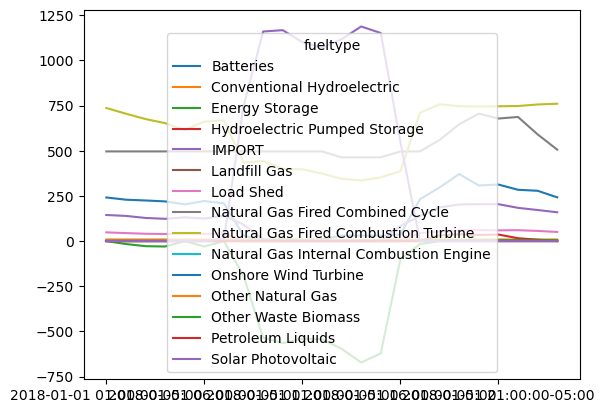

In [427]:
gen.drop(columns=['gen_id', 'bus']).groupby(['fueltype']).sum().T.plot()

In [429]:
grouped = gen.drop(columns=['gen_id', 'bus']).groupby(['fueltype']).sum()
grouped

,2018-01-01 01:00:00-05:00,2018-01-01 02:00:00-05:00,2018-01-01 03:00:00-05:00,2018-01-01 04:00:00-05:00,2018-01-01 05:00:00-05:00,2018-01-01 06:00:00-05:00,2018-01-01 07:00:00-05:00,2018-01-01 08:00:00-05:00,2018-01-01 09:00:00-05:00,2018-01-01 10:00:00-05:00,...,2018-01-01 15:00:00-05:00,2018-01-01 16:00:00-05:00,2018-01-01 17:00:00-05:00,2018-01-01 18:00:00-05:00,2018-01-01 19:00:00-05:00,2018-01-01 20:00:00-05:00,2018-01-01 21:00:00-05:00,2018-01-01 22:00:00-05:00,2018-01-01 23:00:00-05:00,2018-01-02 00:00:00-05:00
fueltype,,,,,,,,,,,,,,,,,,,,,
Batteries,241.579865,229.171659,224.847642,219.726737,203.110664,221.898159,208.664255,30.868979,0.000000,11.683109,...,30.000000,36.368254,231.973735,296.942014,371.262536,307.983649,313.085821,284.072971,278.575713,242.208243
Conventional Hydroelectric,8.900000,8.900000,8.900000,8.900000,8.900000,8.900000,8.900000,8.900000,8.900000,8.900000,...,7.400000,8.900000,8.900000,8.900000,8.900000,8.900000,8.900000,8.900000,8.900000,8.900000
Energy Storage,0.000000,-16.150028,-28.142534,-30.000000,0.000000,-30.000000,0.000000,-191.650239,-536.026772,-564.986555,...,-621.963705,-100.147497,-16.317517,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Hydroelectric Pumped Storage,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,31.546568,37.528832,34.060951,36.256059,15.912436,7.655155,0.000000
IMPORT,144.449133,139.381759,128.150872,123.194368,131.458467,124.764434,141.231111,91.147211,9.971354,0.000000,...,0.000000,83.438884,138.709580,186.292223,203.079100,204.382700,204.335700,184.006871,172.053352,159.611529
Landfill Gas,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Load Shed,48.460967,44.207612,40.705143,39.139454,41.592559,39.638780,44.033271,0.000000,0.000000,0.000000,...,0.000000,0.000000,44.471775,53.457042,59.457404,61.317800,59.443796,60.295863,56.311642,50.579094
Natural Gas Fired Combined Cycle,496.500000,496.500000,496.500000,496.500000,496.500000,496.500000,496.500000,496.500000,496.500000,496.500000,...,463.500000,496.500000,496.500000,559.981524,646.686946,705.774675,678.478946,687.208096,590.754820,506.397886
Natural Gas Fired Combustion Turbine,736.768934,705.224899,675.694877,652.965240,614.904910,661.824727,668.200732,434.743237,443.597008,399.655536,...,352.671278,386.917785,710.369227,757.037328,747.010783,744.510124,746.349079,747.825564,756.300919,760.474247


In [431]:
gen.columns[20:40]

Index(['2018-01-01 21:00:00-05:00', '2018-01-01 22:00:00-05:00',
       '2018-01-01 23:00:00-05:00', '2018-01-02 00:00:00-05:00', 'gen_id',
       'bus', 'fueltype'],
      dtype='object')

In [433]:
prices = pd.read_csv(join(outputs_dir, 'prices.csv'))

In [435]:
prices

,2018-01-01 01:00:00-05:00,2018-01-01 02:00:00-05:00,2018-01-01 03:00:00-05:00,2018-01-01 04:00:00-05:00,2018-01-01 05:00:00-05:00,2018-01-01 06:00:00-05:00,2018-01-01 07:00:00-05:00,2018-01-01 08:00:00-05:00,2018-01-01 09:00:00-05:00,2018-01-01 10:00:00-05:00,...,2018-01-01 15:00:00-05:00,2018-01-01 16:00:00-05:00,2018-01-01 17:00:00-05:00,2018-01-01 18:00:00-05:00,2018-01-01 19:00:00-05:00,2018-01-01 20:00:00-05:00,2018-01-01 21:00:00-05:00,2018-01-01 22:00:00-05:00,2018-01-01 23:00:00-05:00,2018-01-02 00:00:00-05:00
0,34.503963,34.503963,34.503963,34.503963,34.503963,34.503963,34.503963,33.466754,32.654158,28.641362,...,14.885194,33.605746,34.503963,34.420618,34.420618,34.420618,34.420618,34.420618,34.420618,34.431809
1,64.738260,64.738260,64.738260,64.738260,64.738260,64.738260,64.738260,62.763578,49.862531,42.705314,...,19.863177,64.633929,64.738260,63.384929,63.384929,63.384929,63.384929,63.384929,63.384929,63.561043
2,34.503963,34.503963,34.503963,34.503963,34.503963,34.503963,34.503963,33.466754,32.654158,28.641362,...,14.885194,33.605746,34.503963,34.420618,34.420618,34.420618,34.420618,34.420618,34.420618,34.431809
3,34.503963,34.503963,34.503963,34.503963,34.503963,34.503963,34.503963,33.466754,32.654158,28.641362,...,14.885194,33.605746,34.503963,34.420618,34.420618,34.420618,34.420618,34.420618,34.420618,34.431809
4,31.395175,31.395175,31.395175,31.395175,31.395175,31.395175,31.395175,0.000000,0.000000,0.000000,...,0.000000,0.000000,31.395175,31.395175,31.395175,31.395175,31.395175,31.395175,31.395175,31.395175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484,-50.187179,-50.187179,-50.187179,-50.187179,-50.187179,-50.187179,-50.187179,-44.178510,-7.224391,-5.157710,...,-2.005825,-50.187179,-50.187179,-48.149252,-48.149252,-48.149252,-48.149252,-48.149252,-48.149252,-48.390608
485,94.060510,94.060510,94.060510,94.060510,94.060510,94.060510,94.060510,37.328640,37.328640,37.328640,...,37.328640,41.890687,94.060510,94.060510,94.060510,94.060510,94.060510,94.060510,94.060510,94.060510
486,16.535935,16.535935,16.535935,16.535935,16.535935,16.535935,16.535935,15.989621,15.571873,15.552373,...,13.864290,16.045646,16.535935,18.438654,18.438654,18.438654,18.438654,18.438654,18.438654,18.147889
487,20.438354,20.438354,20.438354,20.438354,20.438354,20.438354,20.438354,18.216193,16.759881,16.687203,...,14.925475,18.485718,20.438354,22.466950,22.466950,22.466950,22.466950,22.466950,22.466950,21.984783


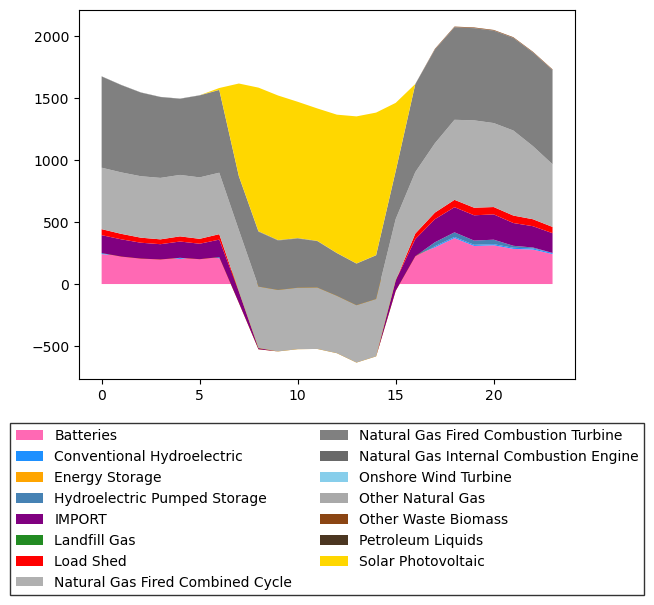

In [437]:
y = grouped.to_numpy()

fig, ax = plt.subplots()
plt.stackplot(range(len(y.T)), y, labels=grouped.index, colors=[i[1] for i in generator_colors]);
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,-0.1), ncol=2, fancybox=False, edgecolor='k')

In [287]:
generator_colors = [
    ("Solar Photovoltaic", "#FFD700"),
    ("Energy Storage", "orange"),
    ("Onshore Wind Turbine", "#87CEEB"),
    ("Conventional Hydroelectric", "#1E90FF"),
    ("Hydroelectric Pumped Storage", "#4682B4"),
    ("Natural Gas Fired Combined Cycle", "#B0B0B0"),
    ("Natural Gas Fired Combustion Turbine", "#808080"),
    ("Natural Gas Internal Combustion Engine", "#696969"),
    ("Other Natural Gas", "#A9A9A9"),
    ("Petroleum Liquids", "#4B3621"),
    ("Landfill Gas", "#228B22"),
    ("Other Waste Biomass", "#8B4513"),
    ("Batteries", "#FF69B4"),
    ("IMPORT", "#800080"),
    ("Load Shed", "#FF0000")
]
generator_colors.sort()

In [289]:
generator_colors

[('Batteries', '#FF69B4'),
 ('Conventional Hydroelectric', '#1E90FF'),
 ('Energy Storage', 'orange'),
 ('Hydroelectric Pumped Storage', '#4682B4'),
 ('IMPORT', '#800080'),
 ('Landfill Gas', '#228B22'),
 ('Load Shed', '#FF0000'),
 ('Natural Gas Fired Combined Cycle', '#B0B0B0'),
 ('Natural Gas Fired Combustion Turbine', '#808080'),
 ('Natural Gas Internal Combustion Engine', '#696969'),
 ('Onshore Wind Turbine', '#87CEEB'),
 ('Other Natural Gas', '#A9A9A9'),
 ('Other Waste Biomass', '#8B4513'),
 ('Petroleum Liquids', '#4B3621'),
 ('Solar Photovoltaic', '#FFD700')]

In [441]:
soc = pd.read_csv(join(outputs_dir, 'soc.csv'))

<Axes: >

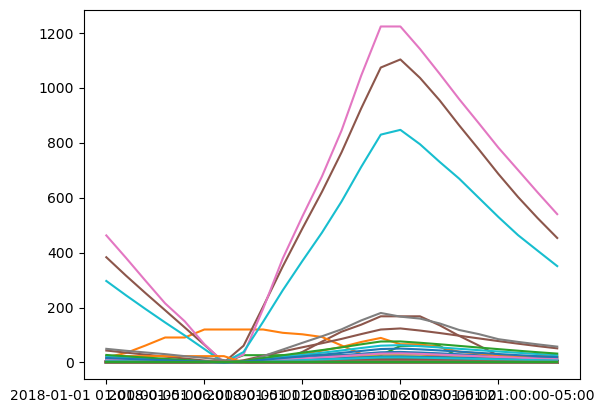

In [443]:
soc.T.iloc[0:-3,:].plot(legend=False)

<Axes: >

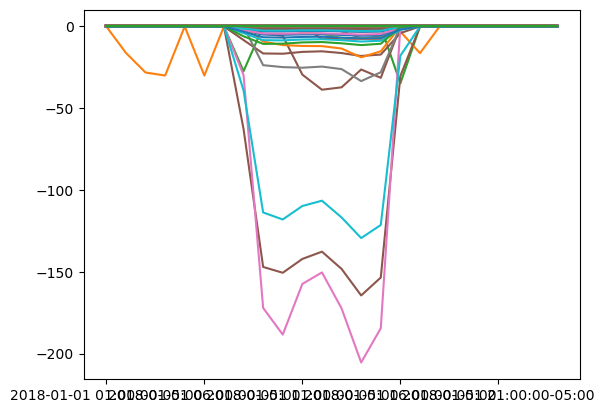

In [439]:
gen[gen['fueltype'] == "Energy Storage"].iloc[:,0:-3].T.plot(legend=False)

<Axes: >

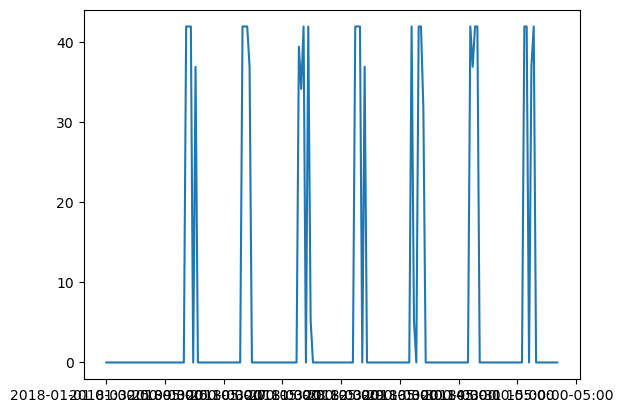

In [326]:
gen[gen['fueltype'] == "Hydroelectric Pumped Storage"].iloc[:,0:-3].T.plot(legend=False)

In [254]:
gen

,2018-01-01 01:00:00-05:00,2018-01-01 02:00:00-05:00,2018-01-01 03:00:00-05:00,2018-01-01 04:00:00-05:00,2018-01-01 05:00:00-05:00,2018-01-01 06:00:00-05:00,2018-01-01 07:00:00-05:00,2018-01-01 08:00:00-05:00,2018-01-01 09:00:00-05:00,2018-01-01 10:00:00-05:00,...,2018-01-01 18:00:00-05:00,2018-01-01 19:00:00-05:00,2018-01-01 20:00:00-05:00,2018-01-01 21:00:00-05:00,2018-01-01 22:00:00-05:00,2018-01-01 23:00:00-05:00,2018-01-02 00:00:00-05:00,gen_id,bus,fueltype
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,5,IMPORT
1,1.4,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,...,1.4,1.4,1.4,1.4,1.4,1.4,1.4,2,7,Conventional Hydroelectric
2,60.5,60.5,60.5,60.5,60.5,60.5,60.500000,60.500000,60.50000,60.500000,...,60.5,60.5,60.5,60.5,60.5,60.5,60.5,3,12,Natural Gas Fired Combustion Turbine
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,13,Batteries
4,0.0,0.0,0.0,0.0,0.0,0.0,0.417614,12.987787,20.37955,20.296027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,13,Solar Photovoltaic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.000000,-0.000000,-0.00000,-0.000000,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,359,458,Energy Storage
1001,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.000000,-0.000000,-0.00000,-0.000000,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,360,87,Energy Storage
1002,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.000000,-0.000000,-0.00000,-0.000000,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,361,68,Energy Storage
1003,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.000000,-0.000000,-0.00000,-0.000000,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,362,91,Energy Storage


In [258]:
battery_gen = gen[gen['gen_id'].isin(soc['gen_id'])]

In [260]:
battery_gen[(battery_gen.drop(columns=['bus']).set_index(['gen_id', 'fueltype']).sum(axis=1) != 0).values]

,2018-01-01 01:00:00-05:00,2018-01-01 02:00:00-05:00,2018-01-01 03:00:00-05:00,2018-01-01 04:00:00-05:00,2018-01-01 05:00:00-05:00,2018-01-01 06:00:00-05:00,2018-01-01 07:00:00-05:00,2018-01-01 08:00:00-05:00,2018-01-01 09:00:00-05:00,2018-01-01 10:00:00-05:00,...,2018-01-01 18:00:00-05:00,2018-01-01 19:00:00-05:00,2018-01-01 20:00:00-05:00,2018-01-01 21:00:00-05:00,2018-01-01 22:00:00-05:00,2018-01-01 23:00:00-05:00,2018-01-02 00:00:00-05:00,gen_id,bus,fueltype


In [301]:
soc[(soc.iloc[:, 20] != 0)]

,2018-01-01 01:00:00-05:00,2018-01-01 02:00:00-05:00,2018-01-01 03:00:00-05:00,2018-01-01 04:00:00-05:00,2018-01-01 05:00:00-05:00,2018-01-01 06:00:00-05:00,2018-01-01 07:00:00-05:00,2018-01-01 08:00:00-05:00,2018-01-01 09:00:00-05:00,2018-01-01 10:00:00-05:00,...,2018-01-01 18:00:00-05:00,2018-01-01 19:00:00-05:00,2018-01-01 20:00:00-05:00,2018-01-01 21:00:00-05:00,2018-01-01 22:00:00-05:00,2018-01-01 23:00:00-05:00,2018-01-02 00:00:00-05:00,gen_id,bus,fueltype
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.74,40.74,81.48,...,129.896907,129.896907,86.597938,86.597938,43.298969,43.298969,0.0,39,100,Hydroelectric Pumped Storage


In [264]:
battery_gen

,2018-01-01 01:00:00-05:00,2018-01-01 02:00:00-05:00,2018-01-01 03:00:00-05:00,2018-01-01 04:00:00-05:00,2018-01-01 05:00:00-05:00,2018-01-01 06:00:00-05:00,2018-01-01 07:00:00-05:00,2018-01-01 08:00:00-05:00,2018-01-01 09:00:00-05:00,2018-01-01 10:00:00-05:00,...,2018-01-01 18:00:00-05:00,2018-01-01 19:00:00-05:00,2018-01-01 20:00:00-05:00,2018-01-01 21:00:00-05:00,2018-01-01 22:00:00-05:00,2018-01-01 23:00:00-05:00,2018-01-02 00:00:00-05:00,gen_id,bus,fueltype
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,13,Batteries
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13,43,Batteries
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15,47,Batteries
19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,54,Batteries
21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22,60,Batteries
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,359,458,Energy Storage
1001,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,360,87,Energy Storage
1002,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,361,68,Energy Storage
1003,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,362,91,Energy Storage


In [299]:
[gen[gen["fueltype"] == "Energy Storage"].iloc[:, i].min() for i in range(24)]

[-0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -42.0,
 -0.0,
 -42.0,
 -0.0,
 -5.1958762886598,
 -0.0,
 -42.0,
 -42.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0]

In [268]:
grouped

,2018-01-01 01:00:00-05:00,2018-01-01 02:00:00-05:00,2018-01-01 03:00:00-05:00,2018-01-01 04:00:00-05:00,2018-01-01 05:00:00-05:00,2018-01-01 06:00:00-05:00,2018-01-01 07:00:00-05:00,2018-01-01 08:00:00-05:00,2018-01-01 09:00:00-05:00,2018-01-01 10:00:00-05:00,...,2018-01-01 15:00:00-05:00,2018-01-01 16:00:00-05:00,2018-01-01 17:00:00-05:00,2018-01-01 18:00:00-05:00,2018-01-01 19:00:00-05:00,2018-01-01 20:00:00-05:00,2018-01-01 21:00:00-05:00,2018-01-01 22:00:00-05:00,2018-01-01 23:00:00-05:00,2018-01-02 00:00:00-05:00
fueltype,,,,,,,,,,,,,,,,,,,,,
Batteries,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000
Conventional Hydroelectric,8.9000,0.0000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0000,8.9000,8.9000,8.9000,8.9000,8.9000,8.9000,8.900
Energy Storage,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000
Hydroelectric Pumped Storage,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000
IMPORT,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000
Landfill Gas,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000
Load Shed,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000
Natural Gas Fired Combined Cycle,998.0000,998.0000,998.000,998.0000,998.0000,998.0000,998.000000,998.000000,998.000000,998.000000,...,995.481739,998.000000,998.0000,998.0000,998.0000,998.0000,998.0000,998.0000,998.0000,998.000
Natural Gas Fired Combustion Turbine,610.4039,549.0049,546.656,510.1198,496.3646,523.5261,574.847853,382.868393,242.042923,184.807614,...,73.200000,365.725943,598.7458,856.2557,1010.8436,983.4989,955.2994,908.5568,809.2756,678.242


In [388]:
0.145*(10**9)

145000000.0